Logs
- [2024/04/30]   
  You do not need to restart this notebook when updating the scratch library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import re
import tqdm
import pickle

from collections import defaultdict
from typing import NamedTuple, List
from scratch.linear_algebra import LinearAlgebra as la
from scratch.working_with_data import DimReduction
from scratch.deep_learning import DeepLearning as dl

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 16,
  'grid.alpha': 0.25})

In [3]:
%load_ext autoreload
%autoreload 2 

## Matrix Factorization

In [4]:
# This points to the current directory, modify if your files are elsewhere.
path_to_file = "./datasets/ml-100k/"
MOVIES = path_to_file + "u.item"   # pipe-delimited: movie_id|title|...
RATINGS = path_to_file + "u.data"  # tab-delimited: user_id, movie_id, rating, timestamp

We define a `Rating` class to make things easier when handling with the data

In [5]:
class Rating(NamedTuple):
  user_id: str
  movie_id: str 
  rating: float

> The `movie_id` and `user_id` are actually integers, but they're not    
> consecutive, which means if we worked with them as integers we'd end up with  
> a lot of wasted dimensions (unless we renumbered everything). So to keep it    
> simpler we'll just treat them as strings.

Let's read in the data and explore it

In [6]:
# We specify this encoding to avoid a UnicodeDecodeError.
# See: https://stackoverflow.com/a/53136168/1076346 -- Encoding issues while reading/importing CSV file in Python3 Pandas
with open(MOVIES, encoding="iso-8859-1") as fp:
  reader = csv.reader(fp, delimiter="|")
  movies = {movie_id: title for movie_id, title, *_ in reader}


In [7]:
# Create a list of [Rating]
with open(RATINGS, encoding="iso-8859-1") as fp:
  reader = csv.reader(fp, delimiter="\t")
  ratings = [Rating(user_id, movie_id, float(rating))
              for user_id, movie_id, rating, _ in reader]

# 1682 movies rated by 943 users
assert len(movies) == 1682
assert len(list({rating.user_id for rating in ratings})) == 943

Print out the datasets

In [8]:
movies

{'1': 'Toy Story (1995)',
 '2': 'GoldenEye (1995)',
 '3': 'Four Rooms (1995)',
 '4': 'Get Shorty (1995)',
 '5': 'Copycat (1995)',
 '6': 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 '7': 'Twelve Monkeys (1995)',
 '8': 'Babe (1995)',
 '9': 'Dead Man Walking (1995)',
 '10': 'Richard III (1995)',
 '11': 'Seven (Se7en) (1995)',
 '12': 'Usual Suspects, The (1995)',
 '13': 'Mighty Aphrodite (1995)',
 '14': 'Postino, Il (1994)',
 '15': "Mr. Holland's Opus (1995)",
 '16': 'French Twist (Gazon maudit) (1995)',
 '17': 'From Dusk Till Dawn (1996)',
 '18': 'White Balloon, The (1995)',
 '19': "Antonia's Line (1995)",
 '20': 'Angels and Insects (1995)',
 '21': 'Muppet Treasure Island (1996)',
 '22': 'Braveheart (1995)',
 '23': 'Taxi Driver (1976)',
 '24': 'Rumble in the Bronx (1995)',
 '25': 'Birdcage, The (1996)',
 '26': 'Brothers McMullen, The (1995)',
 '27': 'Bad Boys (1995)',
 '28': 'Apollo 13 (1995)',
 '29': 'Batman Forever (1995)',
 '30': 'Belle de jour (1967)',
 '31': 'Crimson Tide

In [9]:
ratings

[Rating(user_id='196', movie_id='242', rating=3.0),
 Rating(user_id='186', movie_id='302', rating=3.0),
 Rating(user_id='22', movie_id='377', rating=1.0),
 Rating(user_id='244', movie_id='51', rating=2.0),
 Rating(user_id='166', movie_id='346', rating=1.0),
 Rating(user_id='298', movie_id='474', rating=4.0),
 Rating(user_id='115', movie_id='265', rating=2.0),
 Rating(user_id='253', movie_id='465', rating=5.0),
 Rating(user_id='305', movie_id='451', rating=3.0),
 Rating(user_id='6', movie_id='86', rating=3.0),
 Rating(user_id='62', movie_id='257', rating=2.0),
 Rating(user_id='286', movie_id='1014', rating=5.0),
 Rating(user_id='200', movie_id='222', rating=5.0),
 Rating(user_id='210', movie_id='40', rating=3.0),
 Rating(user_id='224', movie_id='29', rating=3.0),
 Rating(user_id='303', movie_id='785', rating=3.0),
 Rating(user_id='122', movie_id='387', rating=5.0),
 Rating(user_id='194', movie_id='274', rating=2.0),
 Rating(user_id='291', movie_id='1042', rating=4.0),
 Rating(user_id='2

An exploratory data analysis:
- The average ratings for _Star Wars_ movies 

In [8]:
# Data structure for accumulating ratings by movie_id
star_wars_ratings = {movie_id: [] for movie_id, title in movies.items()
                      if re.search("Star Wars|Empire Strikes|Jedi", title)}

# Iterate over ratings, accumulating the Star Wars ones
for rating in ratings:
  if rating.movie_id in star_wars_ratings:
    star_wars_ratings[rating.movie_id].append(rating.rating)

# Compute the average rating for each movie
avg_ratings = [(sum(title_ratings) / len(title_ratings), movie_id)
                for movie_id, title_ratings in star_wars_ratings.items()]

# And then print them in order
for avg_rating, movie_id in sorted(avg_ratings, reverse=True):
  print(f"{avg_rating:.2f} {movies[movie_id]}")

4.36 Star Wars (1977)
4.20 Empire Strikes Back, The (1980)
4.01 Return of the Jedi (1983)


Let's come back to the datasets `movies` and `ratings`. We want to try to come  
up with a a model to predict the ratings. First, we split the ratings data into  
train, validation, and test sets

In [9]:
seed = 24_04_30
rng = np.random.default_rng(seed)

# We re-run ratings data creation to avoid run several times of in-place shuffling
# Create a list of [Rating]
with open(RATINGS, encoding="iso-8859-1") as fp:
  reader = csv.reader(fp, delimiter="\t")
  ratings = [Rating(user_id, movie_id, float(rating))
              for user_id, movie_id, rating, _ in reader]

rng.shuffle(ratings)

split1 = int(len(ratings) * 0.7)
split2 = int(len(ratings) * 0.85)

train = ratings[:split1]              # 70% of the data
validation = ratings[split1:split2]   # 15% of the data
test = ratings[split2:]               # 15% of the data


It is always good to have a simple baseline model and make sure that ours  
constructed model does better than that.

In [10]:
avg_rating = sum(rating.rating for rating in train) / len(train)
baseline_error = sum((rating.rating - avg_rating) ** 2
                      for rating in test) / len(test)

# This is what we hope to do better than
assert 1.26 < baseline_error < 1.27

Creating embeddings for users and movies

In [11]:
seed = 24_04_30
rng = np.random.default_rng(seed)
EMBEDDING_DIM = 2

# Find unique ids
user_ids = {rating.user_id for rating in ratings}
movie_ids = {rating.movie_id for rating in ratings}

# Then create a random vector per id
user_vectors = {user_id: dl.random_tensor(EMBEDDING_DIM, rng=rng) 
                for user_id in user_ids}
movie_vectors = {movie_id: dl.random_tensor(EMBEDDING_DIM, rng=rng) 
                  for movie_id in movie_ids}

[Review in dictionary]   
There is a subtle updating value of dictionary when the dictionary is    
querying and assigning to a new variable. Changing this new variable will    
affect the dictionary

In [12]:
print("A list as a value of a dictionary")
a_dict = {"k1": 2, "k2": [5, 6]}
print(f"a_dict: {a_dict}")

b_list = a_dict["k2"]   # pass by reference not by value!
b_list[0] = -2

print(f"a_dict: {a_dict}")

print("\nA numpy array as a value of a dictionary")
a_dict_with_numpy = {"k1": 2, "k2": np.array([5, 6])}
print(f"a_dict_with_numpy: {a_dict_with_numpy}")

b_numpy = a_dict_with_numpy["k2"]
b_numpy[0] = -2
print(f"a_dict_with_numpy: {a_dict_with_numpy}")

A list as a value of a dictionary
a_dict: {'k1': 2, 'k2': [5, 6]}
a_dict: {'k1': 2, 'k2': [-2, 6]}

A numpy array as a value of a dictionary
a_dict_with_numpy: {'k1': 2, 'k2': array([5, 6])}
a_dict_with_numpy: {'k1': 2, 'k2': array([-2,  6])}


Now we write a training loop for our model

In [13]:
def loop(dataset: List[Rating], learning_rate: float = None) -> None:
  with tqdm.tqdm(dataset) as t:
    loss = 0.0
    for i, rating in enumerate(t):
      movie_vector = movie_vectors[rating.movie_id]  # this is a copy by reference
      user_vector = user_vectors[rating.user_id]     # this is a copy by reference
      predicted = la.dot(user_vector, movie_vector)
      error = predicted - rating.rating
      loss += error ** 2 

      if learning_rate is not None:
        #   predicted = m_0 * u_0 + ... + m_k * u_k
        # So each u_j enters output with coefficient m_j
        # and each m_j enters output with coefficient u_j
        user_gradient = [error * m_j for m_j in movie_vector]
        movie_gradient = [error * u_j for u_j in user_vector]

        # Take gradient steps
        # -- [Note]: updating user_vector and movie_vector will change
        #            user_vectors and movie_vectors
        for j in range(EMBEDDING_DIM):
          user_vector[j] -= learning_rate * user_gradient[j]   
          movie_vector[j] -= learning_rate * movie_gradient[j]
      
      t.set_description(f"avg loss: {loss / (i + 1)}")

In [43]:
# -- Please connect your laptop to the power
N_epochs = 20    #  12 minutes and take a lot of resources
# N_epochs = 50     # 30 minutes

is_train = False 

if is_train:
  learning_rate = 0.05
  for epoch in range(N_epochs):
    learning_rate *= 0.9
    print(epoch, learning_rate)
    loop(train, learning_rate=learning_rate)
    loop(validation)

  loop(test)

0 0.045000000000000005


avg loss: 1.0093278185742829: 100%|██████████| 15000/15000 [00:06<00:00, 2257.15it/s]


1 0.04050000000000001


avg loss: 0.9934161038906597: 100%|██████████| 15000/15000 [00:06<00:00, 2490.04it/s]


2 0.03645000000000001


avg loss: 0.9784275739630338: 100%|██████████| 15000/15000 [00:06<00:00, 2454.22it/s]


3 0.03280500000000001


avg loss: 0.965144815100984: 100%|██████████| 15000/15000 [00:06<00:00, 2425.24it/s] 


4 0.02952450000000001


avg loss: 0.9535455170657577: 100%|██████████| 15000/15000 [00:05<00:00, 2541.94it/s]


5 0.02657205000000001


avg loss: 0.9434854533744493: 100%|██████████| 15000/15000 [00:05<00:00, 2550.73it/s]


6 0.02391484500000001


avg loss: 0.9348010502219687: 100%|██████████| 15000/15000 [00:05<00:00, 2558.21it/s]


7 0.021523360500000012


avg loss: 0.9273337592500874: 100%|██████████| 15000/15000 [00:05<00:00, 2559.72it/s]


8 0.01937102445000001


avg loss: 0.9209362573345031: 100%|██████████| 15000/15000 [00:05<00:00, 2543.92it/s]


9 0.01743392200500001


avg loss: 0.915473685441119: 100%|██████████| 15000/15000 [00:05<00:00, 2501.21it/s] 


10 0.015690529804500006


avg loss: 0.9108235679266712: 100%|██████████| 15000/15000 [00:06<00:00, 2493.51it/s]


11 0.014121476824050006


avg loss: 0.9068754302138561: 100%|██████████| 15000/15000 [00:05<00:00, 2555.87it/s]


12 0.012709329141645007


avg loss: 0.9035303525356417: 100%|██████████| 15000/15000 [00:05<00:00, 2560.83it/s]


13 0.011438396227480507


avg loss: 0.9007004977330557: 100%|██████████| 15000/15000 [00:05<00:00, 2598.61it/s]


14 0.010294556604732457


avg loss: 0.8983086179452641: 100%|██████████| 15000/15000 [00:05<00:00, 2502.28it/s]


15 0.00926510094425921


avg loss: 0.8962875291182418: 100%|██████████| 15000/15000 [00:05<00:00, 2577.28it/s]


16 0.00833859084983329


avg loss: 0.8945795141841185: 100%|██████████| 15000/15000 [00:05<00:00, 2523.94it/s]


17 0.007504731764849962


avg loss: 0.8931355993786239: 100%|██████████| 15000/15000 [00:05<00:00, 2573.44it/s]


18 0.006754258588364966


avg loss: 0.8919146682660807: 100%|██████████| 15000/15000 [00:05<00:00, 2574.29it/s]


19 0.00607883272952847


avg loss: 0.8871084440885508: 100%|██████████| 15000/15000 [00:05<00:00, 2542.62it/s]


Store `movie_vectors` and `user_vectors`

In [44]:
if is_train:
  with open(f"./datasets/movie_vectors_{N_epochs}.dat", "wb") as fp:
    pickle.dump(movie_vectors, fp, protocol=pickle.HIGHEST_PROTOCOL)
  
  with open(f"./datasets/user_vectors_{N_epochs}.dat", "wb") as fp:
    pickle.dump(user_vectors, fp, protocol=pickle.HIGHEST_PROTOCOL)

Load `movie_vectors` and `user_vectors`

In [45]:
with open(f"./datasets/movie_vectors_{N_epochs}.dat", "rb") as fp:
  reload_movie_vectors = pickle.load(fp)

with open(f"./datasets/user_vectors_{N_epochs}.dat", "rb") as fp:
  reload_user_vectors = pickle.load(fp)

We use principal component analysis to inspect the learned vectors

In [46]:
original_vectors = [vector for vector in reload_movie_vectors.values()]
components = DimReduction.pca(original_vectors, 2)

dv: 1067.500: 100%|██████████| 100/100 [00:00<00:00, 203.47it/s]


Let's transform our vectors to represent the principal components and join in   
the movie IDs and average ratings

In [47]:
ratings_by_movie = defaultdict(list)
for rating in ratings:
  ratings_by_movie[rating.movie_id].append(rating.rating)

vectors = [
  (movie_id, sum(ratings_by_movie[movie_id]) / len(ratings_by_movie[movie_id]), 
  movies[movie_id], 
  vector)
  for movie_id, vector in zip(reload_movie_vectors.keys(),
                              DimReduction.transform(original_vectors, components))
]

Print top 25 by first principal component

In [48]:
for row in sorted(vectors, key=lambda v: v[-1][0])[:25]:
  print(row)

('1536', 5.0, 'Aiqing wansui (1994)', [-3.7488526860599842, -0.21841900063685005])
('851', 3.75, 'Two or Three Things I Know About Her (1966)', [-2.922629007794619, 0.1445149643684862])
('1639', 4.333333333333333, 'Bitter Sugar (Azucar Amargo) (1996)', [-2.868924177527388, -1.2896113803238214])
('1367', 4.2, 'Faust (1994)', [-2.7396509480334053, -0.2315622676267648])
('1636', 4.0, 'Brothers in Trouble (1995)', [-2.668552880377418, -1.2462778594806752])
('1602', 3.3333333333333335, 'Price Above Rubies, A (1998)', [-2.6628481092878276, -1.9295192559719136])
('1398', 4.5, 'Anna (1996)', [-2.628944704526476, -0.615774819846693])
('1642', 4.5, "Some Mother's Son (1996)", [-2.562532321207194, -0.9386705394783756])
('1500', 5.0, 'Santa with Muscles (1996)', [-2.562277964543597, 0.5545023685594483])
('1506', 3.6666666666666665, 'Nelly & Monsieur Arnaud (1995)', [-2.5333817146403153, -0.18447881611834616])
('814', 5.0, 'Great Day in Harlem, A (1994)', [-2.528803555156222, 0.4541973671601329])
(

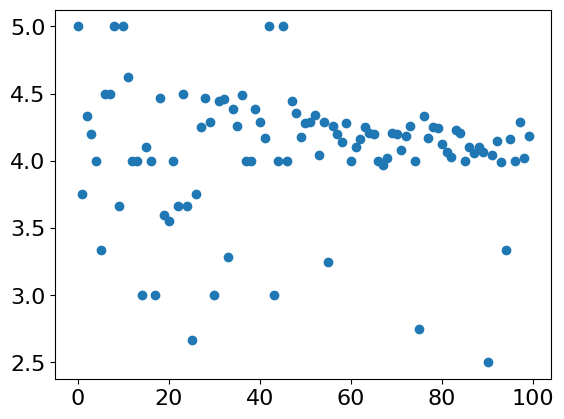

In [49]:
descending_sort = sorted(vectors, key=lambda v: v[-1][0])
fig, ax = plt.subplots()

N_first = 100
movie_id_arr = []
rating_arr = []
for row in descending_sort[:N_first]:
  movie_id_arr.append(row[0])
  rating_arr.append(row[1])

ax.plot(rating_arr, linestyle="None", marker="o")

plt.show(fig)

Print bottom 25 by first principal component

In [50]:
for row in sorted(vectors, key=lambda v: v[-1][0])[-25:]:
  print(row)

('1680', 2.0, 'Sliding Doors (1998)', [-0.08940965117790238, 0.3182259831051655])
('1587', 1.0, 'Terror in a Texas Town (1958)', [-0.056916870677013565, -1.9019696051458785])
('1567', 1.0, 'Careful (1992)', [-0.015388133409840576, -1.6603769347284434])
('857', 3.0, 'Paris Was a Woman (1995)', [-0.014888123687933241, -1.744079152926338])
('1616', 4.0, 'Desert Winds (1995)', [0.04750526204967748, -0.8251326864443571])
('1414', 2.0, 'Coldblooded (1995)', [0.05372942832225197, -0.8316133681510699])
('1559', 1.0, 'Hostile Intentions (1994)', [0.06348776605629941, 1.051153113673923])
('1546', 1.0, 'Shadows (Cienie) (1988)', [0.10943860786930587, 0.689909799294431])
('1461', 2.0, 'Here Comes Cookie (1935)', [0.389922267802574, 0.7625448446472056])
('1617', 3.0, 'Hugo Pool (1997)', [0.42699580777833746, 0.3120411551769384])
('1599', 5.0, "Someone Else's America (1995)", [0.4769035894517216, 2.2384060070994813])
('1564', 1.0, 'To Cross the Rubicon (1991)', [0.5777609890706265, 0.451962695104180

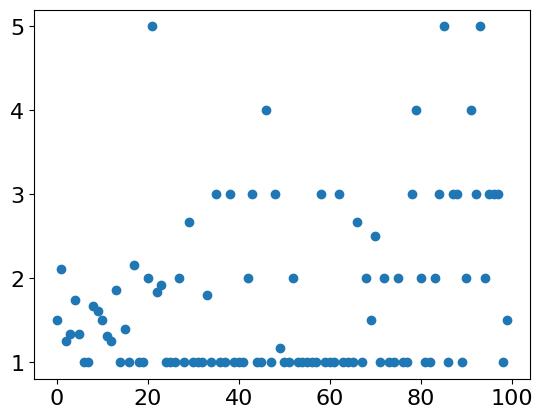

In [51]:
fig, ax = plt.subplots()

N_last = 100
movie_id_arr = []
rating_arr = []
for row in descending_sort[-N_first:]:
  movie_id_arr.append(row[0])
  rating_arr.append(row[1])

ax.plot(rating_arr, linestyle="None", marker="o")

plt.show(fig)